In [2]:
from sklearn.datasets import make_circles

n_samples = 1000

X,y = make_circles(n_samples,noise=0.03,random_state = 42)

In [3]:
X[:5],y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [7]:
import pandas as pd
circles = pd.DataFrame({'X1':X[:,0],'X2':X[:,1],'label':y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [8]:
circles['label'].value_counts()

label
1    500
0    500
Name: count, dtype: int64

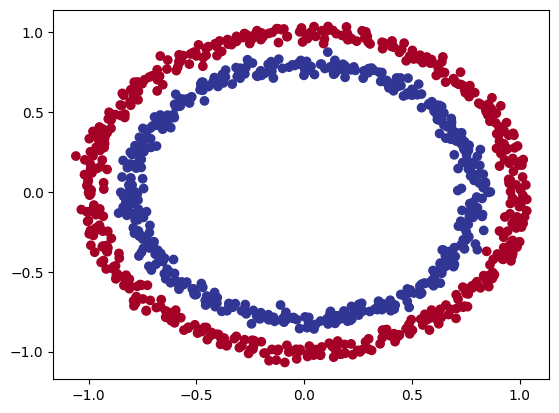

In [9]:
import matplotlib.pyplot as plt

plt.scatter(x=X[:,0],y=X[:,1],c=y,cmap=plt.cm.RdYlBu);

In [10]:
X.shape,y.shape

((1000, 2), (1000,))

In [11]:
x_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {x_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {x_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


In [12]:
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [14]:
X[0].dtype

torch.float32

In [15]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state = 42)
len(X_train),len(X_test),len(y_train),len(y_test)

(800, 200, 800, 200)

In [16]:
from torch import nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [18]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,out_features=5)
    self.layer_2 = nn.Linear(in_features=5,out_features=1)

  def forward(self,x):
    return self.layer_2(self.layer_1(x))

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.4450],
        [-0.5385],
        [-0.3541],
        [-0.4702],
        [-0.5987],
        [-0.6539],
        [-0.7232],
        [-0.7508],
        [-0.3439],
        [-0.5475]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [20]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.1)

In [21]:
def accuracy_fn(y_true,y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [22]:
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.4450],
        [-0.5385],
        [-0.3541],
        [-0.4702],
        [-0.5987]], grad_fn=<SliceBackward0>)

In [23]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.3905],
        [0.3685],
        [0.4124],
        [0.3846],
        [0.3546]], grad_fn=<SigmoidBackward0>)

In [24]:
y_preds = torch.round(y_pred_probs)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))
y_pred_labels

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], grad_fn=<RoundBackward0>)

In [25]:
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

tensor([True, True, True, True, True])


In [26]:
y_preds.squeeze()


tensor([0., 0., 0., 0., 0.], grad_fn=<SqueezeBackward0>)

In [27]:
torch.manual_seed(42)
epochs = 100
X_train,y_train = X_train.to(device),y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)

for epoch in range(epochs):
  model_0.train()
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_train,y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_test,test_pred)

  if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.72950, Accuracy: 50.00% | Test loss: 0.72229, Test acc: 50.00%
Epoch: 10 | Loss: 0.70462, Accuracy: 50.00% | Test loss: 0.70157, Test acc: 50.00%
Epoch: 20 | Loss: 0.69797, Accuracy: 44.88% | Test loss: 0.69632, Test acc: 47.50%
Epoch: 30 | Loss: 0.69592, Accuracy: 48.50% | Test loss: 0.69482, Test acc: 47.00%
Epoch: 40 | Loss: 0.69515, Accuracy: 50.00% | Test loss: 0.69428, Test acc: 46.50%
Epoch: 50 | Loss: 0.69477, Accuracy: 50.12% | Test loss: 0.69400, Test acc: 48.00%
Epoch: 60 | Loss: 0.69453, Accuracy: 50.00% | Test loss: 0.69380, Test acc: 49.50%
Epoch: 70 | Loss: 0.69436, Accuracy: 50.12% | Test loss: 0.69364, Test acc: 50.00%
Epoch: 80 | Loss: 0.69421, Accuracy: 50.12% | Test loss: 0.69351, Test acc: 48.50%
Epoch: 90 | Loss: 0.69409, Accuracy: 50.38% | Test loss: 0.69340, Test acc: 49.00%


In [28]:
import requests
from pathlib import Path
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

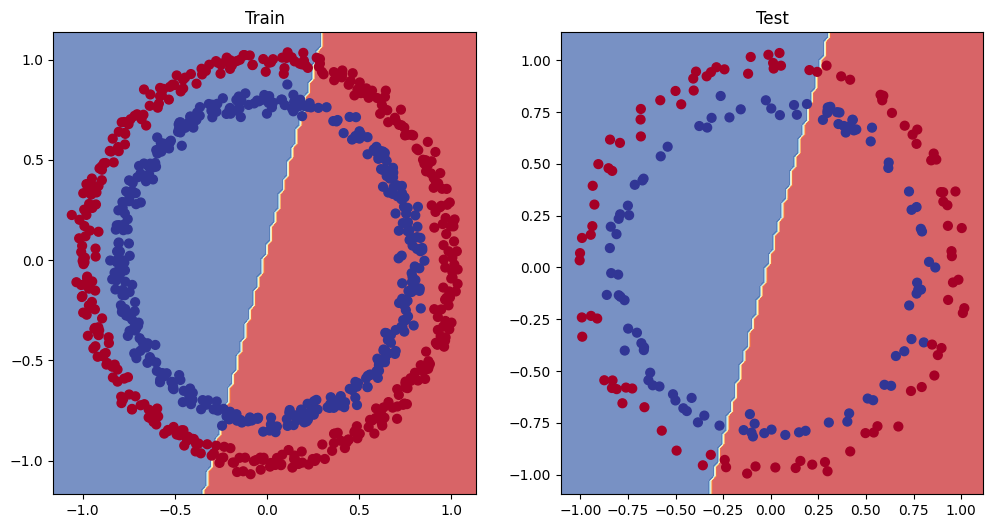

In [29]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [30]:
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01
X_regression = torch.arange(start,end,step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

print(len(X_regression))
X_regression[:5],y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [31]:
train_split = int(0.8*len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split],y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:],y_regression[train_split:]

print(len(X_train_regression),len(y_train_regression),len(X_test_regression),len(y_test_regression))

80 80 20 20


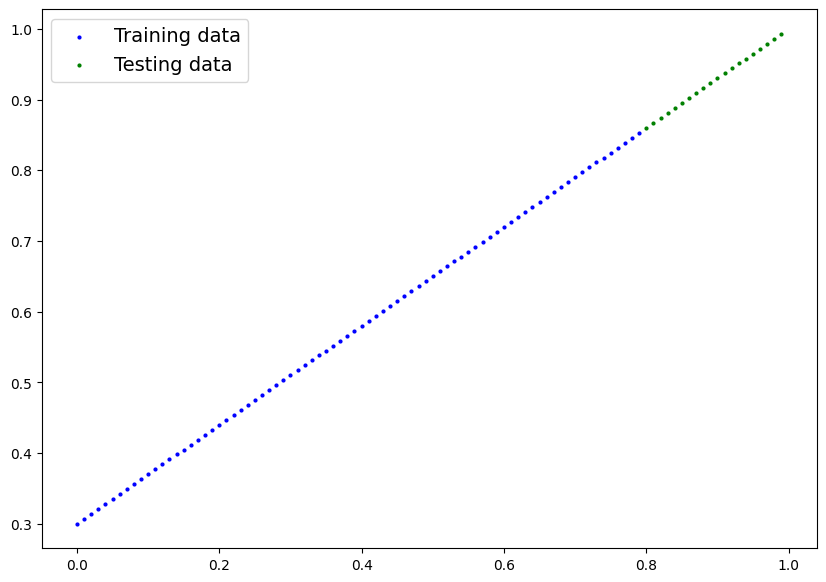

In [32]:
plot_predictions(train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression
);

In [33]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1,out_features=10),
    nn.Linear(in_features=10,out_features=10),
    nn.Linear(in_features=10,out_features=1),
).to(device)
model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [34]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(),lr=0.1)

In [35]:
torch.manual_seed(42)
epochs = 1000
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred,y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred,y_test_regression)

  if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")


Epoch: 0 | Train loss: 0.75986, Test loss: 0.54143
Epoch: 100 | Train loss: 0.09309, Test loss: 0.02901
Epoch: 200 | Train loss: 0.07376, Test loss: 0.02850
Epoch: 300 | Train loss: 0.06745, Test loss: 0.00615
Epoch: 400 | Train loss: 0.06107, Test loss: 0.02004
Epoch: 500 | Train loss: 0.05698, Test loss: 0.01061
Epoch: 600 | Train loss: 0.04857, Test loss: 0.01326
Epoch: 700 | Train loss: 0.06109, Test loss: 0.02127
Epoch: 800 | Train loss: 0.05600, Test loss: 0.01425
Epoch: 900 | Train loss: 0.05571, Test loss: 0.00603


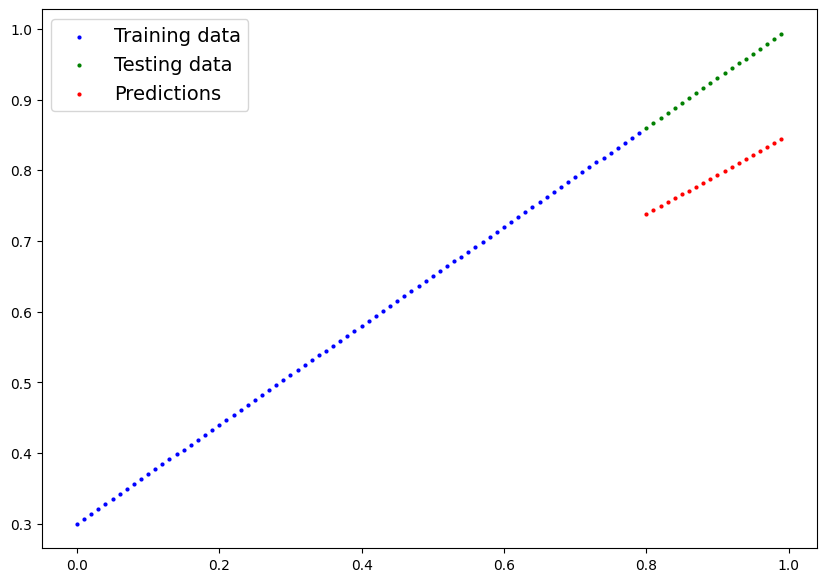

In [36]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression,
                 predictions=y_preds);

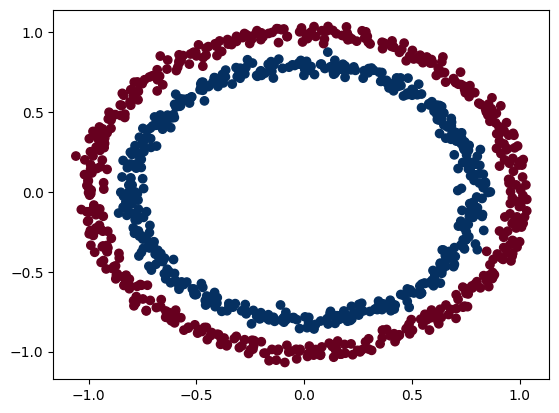

In [37]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [38]:
# Convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [40]:
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,out_features=10)
    self.layer_2 = nn.Linear(in_features=10,out_features=10)
    self.layer_3 = nn.Linear(in_features=10,out_features=1)
    self.relu = nn.ReLU()

  def forward(self,x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)


CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [41]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(),lr=0.1)

In [43]:
torch.manual_seed(42)
epochs = 1000
X_train,y_train = X_train.to(device),y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)

for epoch in range(epochs):
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_train,y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_test,test_pred)
  if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%


In [44]:
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

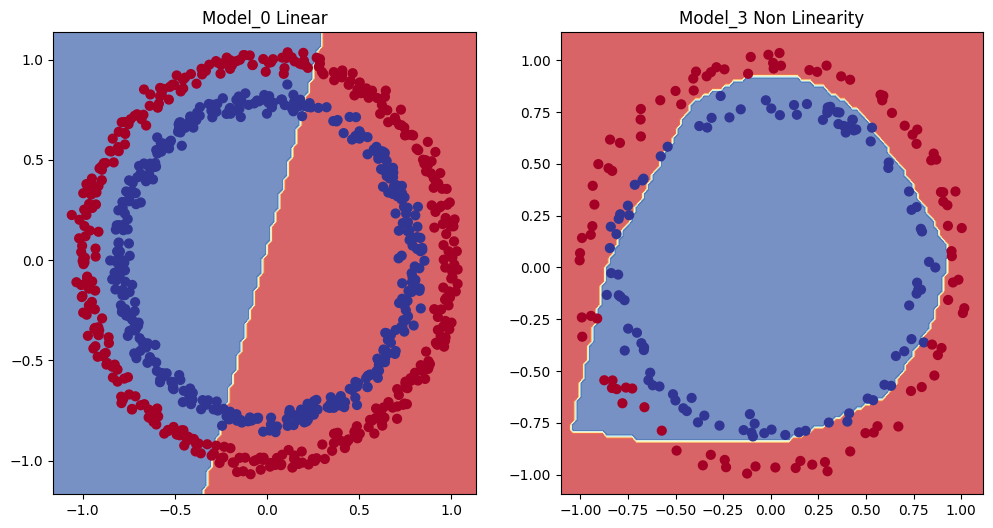

In [48]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Model_0 Linear")
plot_decision_boundary(model_0, X_train, y_train) # model_0 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Model_3 Non Linearity")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661]]) tensor([3., 2., 2.])


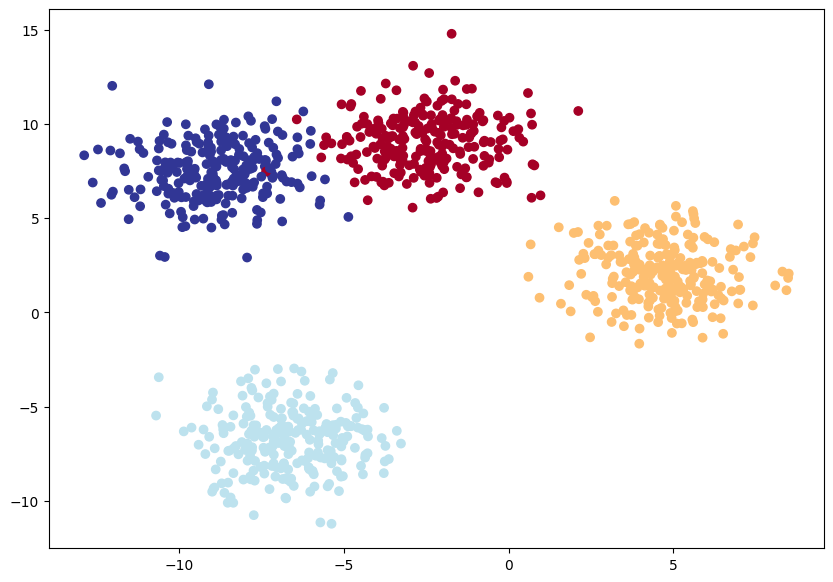

In [51]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

num_classes = 4
num_features = 2
random_seed =42

X_blob,y_blob = make_blobs(n_samples=1000
                           ,n_features=num_features,
                           centers=num_classes,cluster_std=1.5,
                           random_state=random_seed)
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)
print(X_blob[:3],y_blob[:3])
X_blob_train,X_blob_test,y_blob_train,y_blob_test = train_test_split(X_blob,y_blob,test_size=0.2,random_state=random_seed)
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob,cmap=plt.cm.RdYlBu);

In [52]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [89]:
class BlobModel(nn.Module):
  def __init__(self,input_features,output_features,hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features,out_features=hidden_units),
        nn.Linear(in_features = hidden_units,out_features = hidden_units),
        nn.Linear(in_features = hidden_units, out_features = output_features),
    )

  def forward(self,x):
    return self.linear_layer_stack(x)

model_4 = BlobModel(input_features = num_features, output_features = num_classes,hidden_units=8).to(device)


In [90]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),lr=0.1)

In [91]:
model_4(X_blob_train.to(device))[:5]

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], grad_fn=<SliceBackward0>)

In [92]:
y_logits = model_4(X_blob_test.to(device))
y_pred_probs = torch.softmax(y_logits,dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]], grad_fn=<SliceBackward0>)
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]], grad_fn=<SliceBackward0>)


In [93]:
torch.sum(y_pred_probs[0])

tensor(1., grad_fn=<SumBackward0>)

In [94]:
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1872, 0.2918, 0.1495, 0.3715], grad_fn=<SelectBackward0>)
tensor(3)


In [95]:
y_blob_train.dtype

torch.float32

In [103]:
torch.manual_seed(42)
epochs = 100
X_blob_train,y_blob_train = X_blob_train.to(device),y_blob_train.to(device)
X_blob_test,y_blob_test = X_blob_test.to(device),y_blob_test.to(device)
for epoch in range(epochs):
  model_4.train()
  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1)
  loss = loss_fn(y_logits,y_blob_train.type(torch.long))
  acc = accuracy_fn(y_blob_train,y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_pred = torch.softmax(test_logits,dim=1).argmax(dim=1)
    test_loss = loss_fn(test_logits,y_blob_test.type(torch.long))
    test_acc = accuracy_fn(y_blob_test,test_pred)

  if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.02700, Acc: 99.12% | Test Loss: 0.01695, Test Acc: 99.50%
Epoch: 10 | Loss: 0.02680, Acc: 99.12% | Test Loss: 0.01667, Test Acc: 99.50%
Epoch: 20 | Loss: 0.02662, Acc: 99.12% | Test Loss: 0.01642, Test Acc: 99.50%
Epoch: 30 | Loss: 0.02645, Acc: 99.12% | Test Loss: 0.01618, Test Acc: 99.50%
Epoch: 40 | Loss: 0.02630, Acc: 99.25% | Test Loss: 0.01597, Test Acc: 99.50%
Epoch: 50 | Loss: 0.02617, Acc: 99.25% | Test Loss: 0.01577, Test Acc: 99.50%
Epoch: 60 | Loss: 0.02604, Acc: 99.25% | Test Loss: 0.01558, Test Acc: 99.50%
Epoch: 70 | Loss: 0.02592, Acc: 99.25% | Test Loss: 0.01541, Test Acc: 99.50%
Epoch: 80 | Loss: 0.02581, Acc: 99.25% | Test Loss: 0.01524, Test Acc: 99.50%
Epoch: 90 | Loss: 0.02571, Acc: 99.25% | Test Loss: 0.01509, Test Acc: 99.50%


In [106]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)
y_logits[:10]

tensor([[  5.9155,  14.6190, -19.4248, -12.7685],
        [  6.5870, -17.2332,   4.7312,  14.0877],
        [ -7.9418, -18.4001,  27.0045,  16.2739],
        [  2.4646,  10.8127, -11.3487,  -9.2675],
        [ 10.9479,   4.3417, -18.7082,  -4.5011],
        [  7.3345, -21.4114,   6.9309,  17.5560],
        [ -8.4335, -13.8952,  24.1711,  12.5083],
        [  9.5369,  -1.3477, -12.1435,   0.4224],
        [ -8.0061, -25.8639,  32.9906,  22.5853],
        [  9.8805,   0.7390, -14.2957,  -1.3690]])

In [108]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_preds = y_pred_probs.argmax(dim=1)

print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels: tensor([1., 3., 2., 1., 0., 3., 2., 0., 2., 0.])
Test accuracy: 99.5%


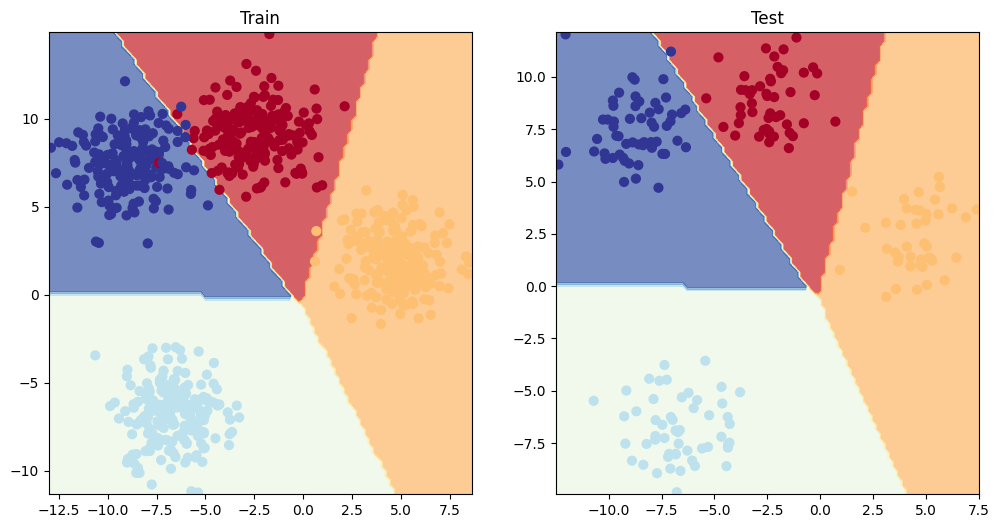

In [109]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)